In [ ]:
! pip3 -q install optax

     |████████████████████████████████| 140 kB 4.0 MB/s 
     |████████████████████████████████| 72 kB 517 kB/s 


In [ ]:
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [ ]:
! git init .
! git remote add origin https://github.com/VLSF/SNO
! git pull origin main

In [ ]:
from architectures import FNO_1D as fno

from datasets import Derivatives, Indefinite_Integrals
from functions import Chebyshev, utils

# FNO 1D

## Write, load and count

In [ ]:
params_encoder = fno.init_c_network_params([2, 20], random.PRNGKey(11))
params_i = fno.init_i_network_params([20, 20, 20, 20], [14, 14, 14, 14], random.PRNGKey(11))
params_decoder = fno.init_c_network_params([20, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

In [ ]:
fno.count_params(params)

34941

In [ ]:
fno.save_params(params, "experiment_23", "fno_run_134")
params_ = fno.load_params("experiment_23", "fno_run_134")

In [ ]:
print("Same number of layers --", [len(p) == len(p_) for p, p_ in zip(params, params_)])
print("====")

for p, p_ in zip(params, params_):
  for i in range(len(p)):
    print("Layer " + str(i))
    for j in range(len(p[i])):
      print(jnp.all(p[i][j] == p_[i][j]))
    print("====")

Same number of layers -- [True, True, True]
====
Layer 0
True
True
====
Layer 0
True
True
True
True
====
Layer 1
True
True
True
True
====
Layer 2
True
True
True
True
====
Layer 0
True
True
====


## Training I

Initialize network

In [ ]:
params_encoder = fno.init_c_network_params([2, 20], random.PRNGKey(11))
params_i = fno.init_i_network_params([20, 20, 20, 20], [14, 14, 14, 14], random.PRNGKey(11))
params_decoder = fno.init_c_network_params([20, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

Initialize optimizer

In [ ]:
sc = optax.exponential_decay(0.001, 5000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params)

Create dataset

In [ ]:
N_samples = 500
Data = Indefinite_Integrals.Fourier_series(10, 50, 2*N_samples, key=random.PRNGKey(1729), sigma=2, periodic=True, return_coefficients=False)

x = jnp.stack([utils.grid(50, periodic=True)]*1000, 0)
train = (jnp.stack([x[:250], Data[0][:250]], -1), jnp.expand_dims(Data[1][:250], -1))
test = (jnp.stack([x[250:], Data[0][250:]], -1), jnp.expand_dims(Data[1][250:], -1))

In [ ]:
%timeit -o utils.update_params(params, train[0], train[1], optimizer, opt_state, fno.loss);

100 loops, best of 5: 5.57 ms per loop


<TimeitResult : 100 loops, best of 5: 5.57 ms per loop>

In [ ]:
res = _
mean_t = sum(r/res.loops for r in res.all_runs) / len(res.all_runs)
N_epochs = 20000

minutes = N_epochs*mean_t/60

print("Optimization will take ", round(minutes, ndigits=2), " minutes")

Optimization will take  1.86  minutes


In [ ]:
train_loss = []
test_loss = []

test_loss.append(fno.loss(params, test[0], test[1]))
train_loss.append(fno.loss(params, train[0], train[1]))

print(train_loss[-1])
print(test_loss[-1])

3.0573034473710097
3.0624373036933843


In [ ]:
for i in range(N_epochs):
  params, opt_state = utils.update_params(params, train[0], train[1], optimizer, opt_state, fno.loss)
  if (i+1)%100 == 0:
    test_loss.append(fno.loss(params, test[0], test[1]))
    train_loss.append(fno.loss(params, train[0], train[1]))

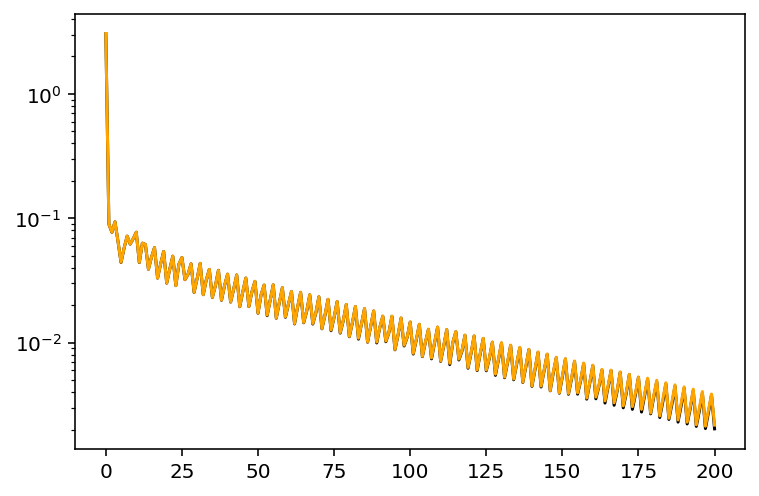

In [ ]:
plt.yscale("log")
plt.plot(train_loss, color="black")
plt.plot(test_loss, color="orange");

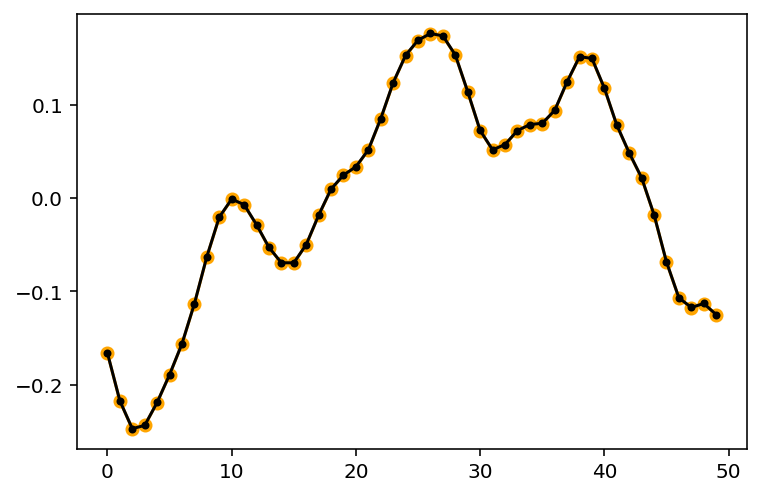

In [ ]:
N = 0
plt.plot(fno.NN(params, train[0][N]), "o-", color="orange")
plt.plot(train[1][N], ".-", color="black");

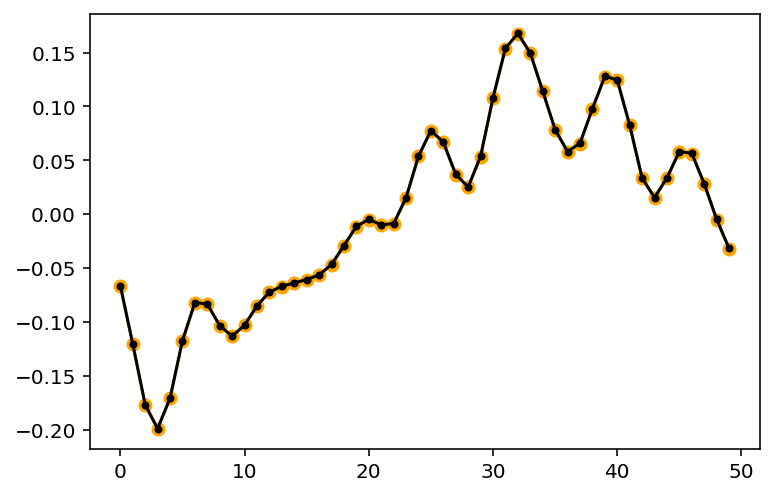

In [ ]:
N = 13
plt.plot(fno.NN(params, test[0][N]), "o-", color="orange")
plt.plot(test[1][N], ".-", color="black");

Mean relative test error 0.0037969063825229986


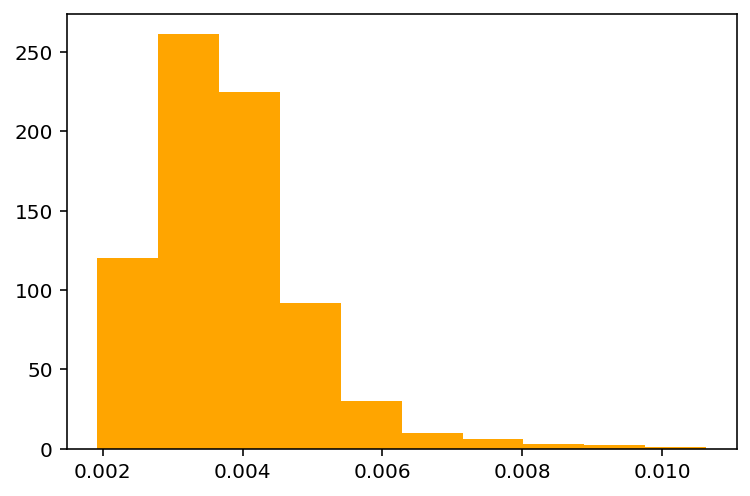

In [ ]:
predictions = fno.batched_NN(params, test[0]).reshape(750, 50)
relative_errors = jnp.linalg.norm(predictions - test[1].reshape(750, 50), axis=1) / jnp.linalg.norm(test[1].reshape(750, 50), axis=1)
plt.hist(relative_errors, color="orange")
mean_relative_test_error = jnp.mean(relative_errors)
print("Mean relative test error", mean_relative_test_error);

## Training II

In [ ]:
params_encoder = fno.init_c_network_params([2, 20], random.PRNGKey(11))
params_i = fno.init_i_network_params([20, 20, 20, 20], [14, 14, 14, 14], random.PRNGKey(11))
params_decoder = fno.init_c_network_params([20, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

sc = optax.exponential_decay(0.001, 5000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params)

N_samples = 500
Data = Derivatives.Fourier_series(10, 50, 2*N_samples, key=random.PRNGKey(1729), sigma=2, periodic=True, return_coefficients=False)

x = jnp.stack([utils.grid(50, periodic=True)]*1000, 0)
train = (jnp.stack([x[:250], Data[0][:250]], -1), jnp.expand_dims(Data[1][:250], -1))
test = (jnp.stack([x[250:], Data[0][250:]], -1), jnp.expand_dims(Data[1][250:], -1))

In [ ]:
train_loss = []
test_loss = []

test_loss.append(fno.loss(params, test[0], test[1]))
train_loss.append(fno.loss(params, train[0], train[1]))

print(train_loss[-1])
print(test_loss[-1])

96.92424839702437
96.35964107589221


In [ ]:
for i in range(N_epochs):
  # run in a single batch
  params, opt_state = utils.update_params(params, train[0], train[1], optimizer, opt_state, fno.loss)
  if (i+1)%100 == 0:
    test_loss.append(fno.loss(params, test[0], test[1]))
    train_loss.append(fno.loss(params, train[0], train[1]))

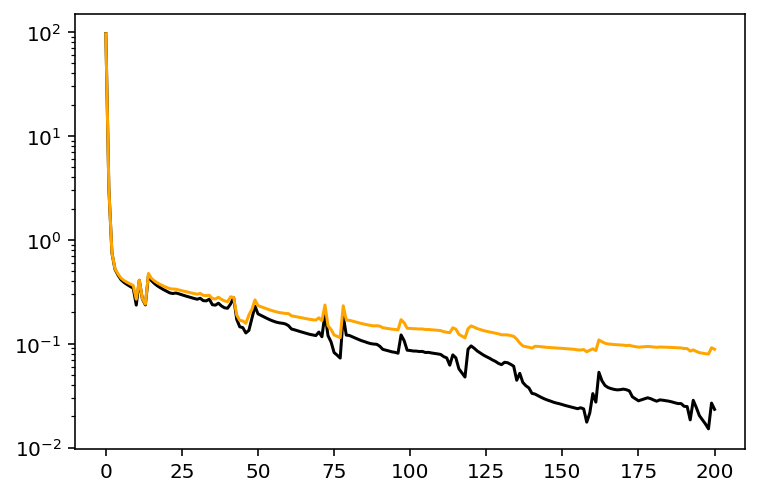

In [ ]:
plt.yscale("log")
plt.plot(train_loss, color="black")
plt.plot(test_loss, color="orange");

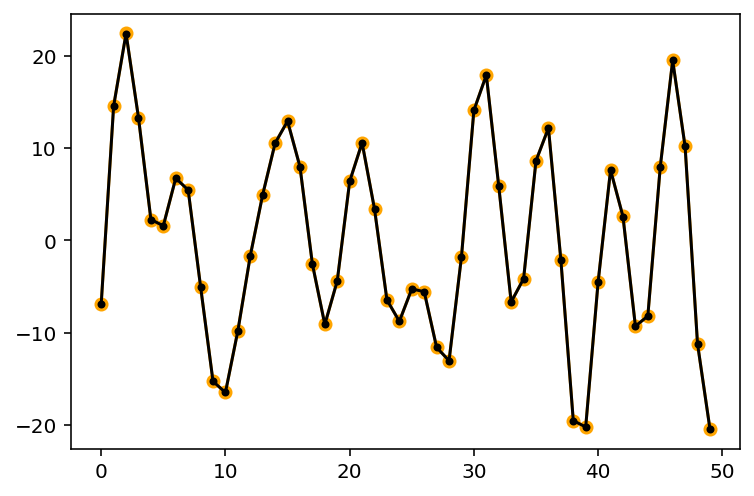

In [ ]:
N = 0
plt.plot(fno.NN(params, train[0][N]), "o-", color="orange")
plt.plot(train[1][N], ".-", color="black");

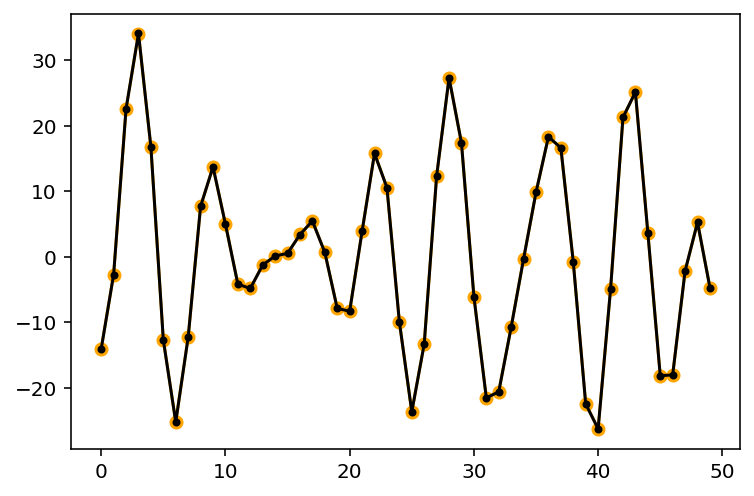

In [ ]:
N = 13
plt.plot(fno.NN(params, test[0][N]), "o-", color="orange")
plt.plot(test[1][N], ".-", color="black");

Mean relative test error 0.000860822243023371


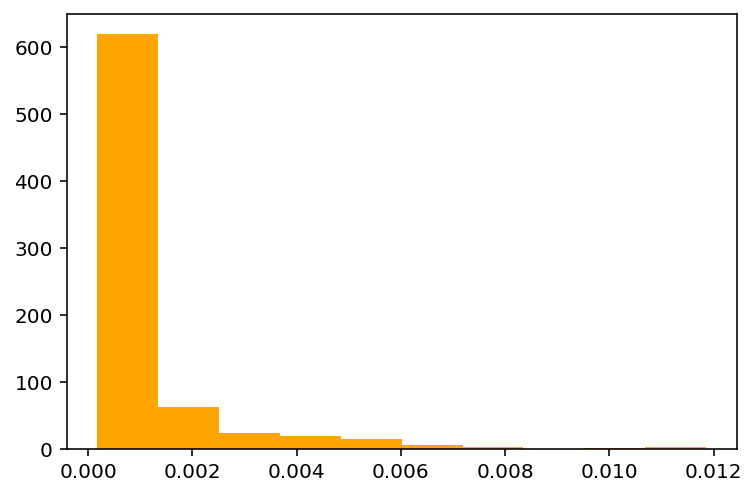

In [ ]:
predictions = fno.batched_NN(params, test[0]).reshape(750, 50)
relative_errors = jnp.linalg.norm(predictions - test[1].reshape(750, 50), axis=1) / jnp.linalg.norm(test[1].reshape(750, 50), axis=1)
plt.hist(relative_errors, color="orange")
mean_relative_test_error = jnp.mean(relative_errors)
print("Mean relative test error", mean_relative_test_error);

# FNO 2D

In [ ]:
from architectures import FNO_2D as fno
from functions import utils

from datasets import KdV_exact

## Write, load and count

In [ ]:
params_encoder = fno.init_c_network_params([2, 32], random.PRNGKey(11))
params_i = fno.init_i_network_params([32, 32, 32, 32, 32], [12, 12, 12, 12, 12], random.PRNGKey(11))
params_decoder = fno.init_c_network_params([32, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

fno.count_params(params)

2363649

In [ ]:
params_encoder = fno.init_c_network_params([2, 20], random.PRNGKey(11))
params_i = fno.init_i_network_params([20, 20, 20, 20], [14, 14, 14, 14], random.PRNGKey(11))
params_decoder = fno.init_c_network_params([20, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

In [ ]:
fno.count_params(params)

942141

In [ ]:
fno.save_params(params, "experiment_23", "fno_run_134")
params_ = fno.load_params("experiment_23", "fno_run_134")

In [ ]:
print("Same number of layers --", [len(p) == len(p_) for p, p_ in zip(params, params_)])
print("====")

for p, p_ in zip(params, params_):
  for i in range(len(p)):
    print("Layer " + str(i))
    for j in range(len(p[i])):
      print(jnp.all(p[i][j] == p_[i][j]))
    print("====")

Same number of layers -- [True, True, True]
====
Layer 0
True
True
====
Layer 0
True
True
True
True
====
Layer 1
True
True
True
True
====
Layer 2
True
True
True
True
====
Layer 0
True
True
====


## Training I

Initialize network

In [ ]:
params_encoder = fno.init_c_network_params([3, 10], random.PRNGKey(11))
params_i = fno.init_i_network_params([10, 10, 10, 10], [14, 14, 14, 14], random.PRNGKey(11))
params_decoder = fno.init_c_network_params([10, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

Initialize optimizer

In [ ]:
sc = optax.exponential_decay(0.001, 5000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params)

Create dataset

In [ ]:
N_samples = 100
Data = KdV_exact.KdV_2D(100, 100, N_samples, key=random.PRNGKey(1729), periodic=True, return_coefficients=False)

x = utils.grid(100, periodic=True)
t = 0.0005 * (utils.grid(100, periodic=True) + 1) / 2
x, t = jnp.meshgrid(x, t, indexing="ij")
X = jnp.stack([x]*N_samples, 0)
T = jnp.stack([t]*N_samples, 0)

train = (jnp.stack([X[:50], T[:50], Data[0][:50]], -1), jnp.expand_dims(Data[1][:50], -1))
test = (jnp.stack([X[:50], T[:50], Data[0][50:]], -1), jnp.expand_dims(Data[1][50:], -1))

In [ ]:
%timeit -o utils.update_params(params, train[0], train[1], optimizer, opt_state, fno.loss);

10 loops, best of 5: 105 ms per loop


<TimeitResult : 10 loops, best of 5: 105 ms per loop>

In [ ]:
res = _
mean_t = sum(r/res.loops for r in res.all_runs) / len(res.all_runs)
N_epochs = 1000

minutes = N_epochs*mean_t/60

print("Optimization will take ", round(minutes, ndigits=2), " minutes")

Optimization will take  1.75  minutes


In [ ]:
train_loss = []
test_loss = []

test_loss.append(fno.loss(params, test[0], test[1]))
train_loss.append(fno.loss(params, train[0], train[1]))

print(train_loss[-1])
print(test_loss[-1])

27553.788271222125
24566.702219230065


In [ ]:
for i in range(N_epochs):
  params, opt_state = utils.update_params(params, train[0], train[1], optimizer, opt_state, fno.loss)
  if (i+1)%5 == 0:
    test_loss.append(fno.loss(params, test[0], test[1]))
    train_loss.append(fno.loss(params, train[0], train[1]))

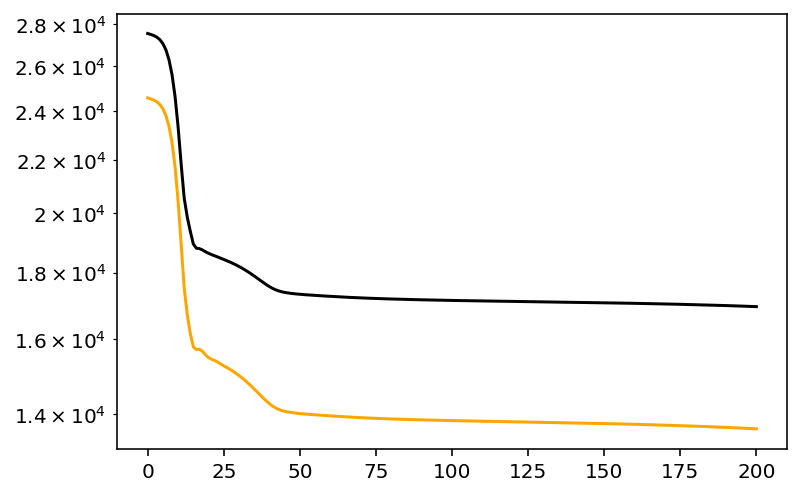

In [ ]:
plt.yscale("log")
plt.plot(train_loss, color="black")
plt.plot(test_loss, color="orange");

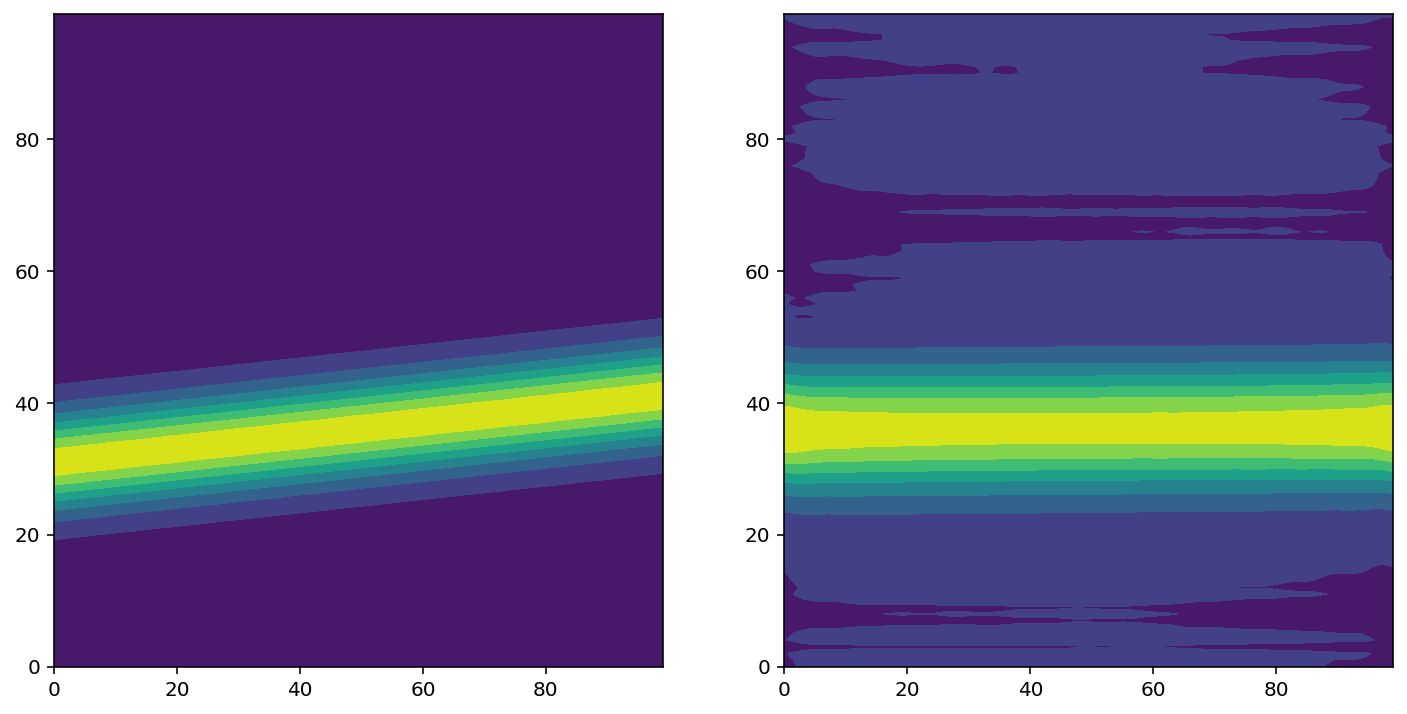

In [ ]:
N = 3

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].contourf(test[1][N].reshape(100, 100))
ax[1].contourf(fno.NN(params, test[0][N]).reshape(100, 100));

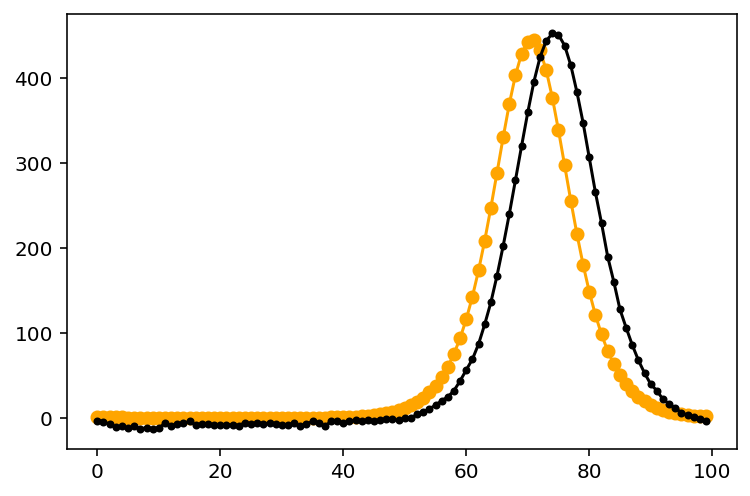

In [ ]:
N = 13
plt.plot(train[1][N][:, 0, 0], "o-", color="orange")
plt.plot(fno.NN(params, train[0][N])[:, 0, 0], ".-", color="black");

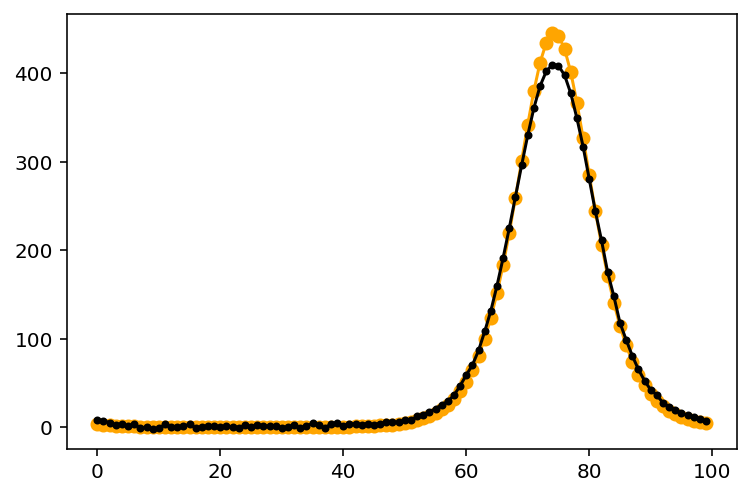

In [ ]:
N = 13
plt.plot(train[1][N][:, 50, 0], "o-", color="orange")
plt.plot(fno.NN(params, train[0][N])[:, 50, 0], ".-", color="black");